------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [143]:
!python --version

Python 3.7.12


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [144]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [145]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2021-11-17 22:29:41--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.5’

sent_lexicon.5      100%[===================>] 647.05K  --.-KB/s    in 0.04s   

2021-11-17 22:29:42 (14.6 MB/s) - ‘sent_lexicon.5’ saved [662577/662577]

--2021-11-17 22:29:42--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercont

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [146]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [147]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [148]:
# YOUR CODE HERE
def create_lexicon_dict():
  sent_lexicon = {}
  with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
      split_line = line.split(" ")
      magnitude = split_line[0].split("=")[1]
      word = split_line[2].split("=")[1]
      polarity = split_line[-1].split("=")[1][:-1]
      sent_lexicon[word] = [polarity, magnitude]
  return sent_lexicon

def s_binary(review, sent_lexicon, weight):
  binary_count = 0
  num_words = 0
  for sentence in review['content']:
    for word, _ in sentence:
      word = word.lower()
      try:
        [polarity, magnitude] = sent_lexicon[word]
        if magnitude == 'strongsubj':
          w = weight
        elif magnitude == 'weaksubj':
          w = 1

        if polarity == 'positive':
          binary_count += (1 * w)
        elif polarity == 'negative':
          binary_count -= (1 * w)
        num_words += 1 * w
      except:
        pass
  return binary_count, num_words

def lexicon_classification(reviews, threshold=8, weight=1):
  sent_lexicon = create_lexicon_dict()
  token_results = []
  binary_counts = []
  for review in reviews:
    label = review['sentiment']
    binary_count, _ = s_binary(review, sent_lexicon, weight)
    binary_counts.append(binary_count)
    if binary_count > threshold:
      binary_score = 1
    else:
      binary_score = 0
    if (binary_score == 1 and label == 'POS') or (binary_score == 0 and label == 'NEG'):
      token_results.append(1)
    else:
      token_results.append(0)
  return token_results, np.mean(binary_counts)

def calculate_acc(token_results):
  return sum(token_results) / len(token_results)



In [149]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results, _ = lexicon_classification(reviews)
token_accuracy = calculate_acc(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [150]:
# YOUR CODE HERE
weight_val = 2
_, weighted_threshold = lexicon_classification(reviews, threshold=8, weight=weight_val)
print("Threshold to use:", weighted_threshold)
weighted_token_results, _ = lexicon_classification(reviews, threshold=weighted_threshold, weight=weight_val)

Threshold to use: 10.8195


In [151]:
magnitude_results = weighted_token_results # a list of binary indicators
magnitude_accuracy = calculate_acc(magnitude_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.69


#### (Q.1.4) Make a barplot of the two results (0.5pt)

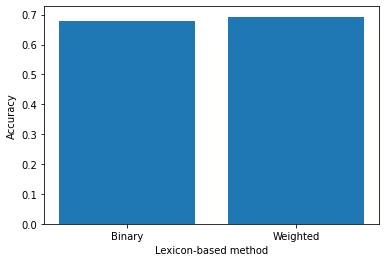

In [152]:
# YOUR CODE HERE
plt.figure()
x = np.arange(2)
plt.bar(x, [token_accuracy, magnitude_accuracy])
plt.xticks(x, ["Binary", "Weighted"])
plt.xlabel("Lexicon-based method")
plt.ylabel("Accuracy")
plt.show()

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

**Answer**

We have a bias of positive words occuring more frequently in text and we use this bias to set a hard threshold that is used for all documents, not taking length into account. However, because of the bias of positive words occuring more frequently, longer documents have higher probability to exceed the hard threshold set over all documents. Conversely, short documents will often not be able to surpass the hard threshold, even if overall sentiment is positive.
An alternative way to compute the threshold would be to implement a flexible threshold $T$ that, for a review $d_i$, we calculate by multiplying the average bias with a weight that takes this effect of document length into account. We can define this formally as:

$T_{d_i} = \text{avg_bias} \times \Big(\frac{dl_i}{\frac{1}{N} \sum_j^N dl_j}\Big)$

Where avg_bias is the average bias between positive/negative occurences throughout the whole corpus, $dl_i$ is the number of positive/negative words in the review (document length) and $\frac{dl_i}{\frac{1}{N} \sum_j^N dl_j}\Big)$ is the average document length. This way, the threshold for relatively short documents will be multiplied with a weight < 1 and relatively long documents with a weight > 1.

In [153]:
# YOUR CODE HERE
def get_statistics(reviews, weight):
  sent_lexicon = create_lexicon_dict()
  binary_counts = []
  doc_lengths = []
  for review in reviews:
    binary_count, num_words = s_binary(review, sent_lexicon, weight)
    binary_counts.append(binary_count)
    doc_lengths.append(num_words)
  return np.mean(binary_counts), np.mean(doc_lengths)

def flexible_threshold_classification(reviews, avg_binary_diff, avg_doc_length, weight=1):
  sent_lexicon = create_lexicon_dict()
  token_results = []
  for review in reviews:
    label = review['sentiment']
    binary_count, num_words = s_binary(review, sent_lexicon, weight)

    threshold = avg_binary_diff * (num_words / avg_doc_length)
    if binary_count > threshold:
      binary_score = 1
    else:
      binary_score = 0
    if (binary_score == 1 and label == 'POS') or (binary_score == 0 and label == 'NEG'):
      token_results.append(1)
    else:
      token_results.append(0)
  return token_results

weight_val = 2
avg_bias, avg_doc_length = get_statistics(reviews, weight=weight_val)
print("Avg bias:", avg_bias)
print("Avg doc length:", avg_doc_length)
flexible_thresh_tokens = flexible_threshold_classification(reviews, avg_bias, avg_doc_length, weight=weight_val) 
flexible_acc = calculate_acc(flexible_thresh_tokens)
print("Accuracy: %0.3f" % flexible_acc)

Avg bias: 10.8195
Avg doc length: 144.646
Accuracy: 0.698


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 


**Answer** 

We compute the probability of a review belong to a class in the log space, and because per definition: 0 <= p(w|c) <= 1, taking the log results in a negative number. So actually, in computing the class we take the highest negative number in the argmax operation. So if we have a word that, during training, we have seen for class C_1 but not for class C_2 and we decide to skip the word in inferring the log probability score for class C_2 but not for class C_1, we actually "punish" the overall score for class C_1 because we add an extra negative term to the overall score for this class. Put differently, skipping a word for the class in which it was not seen makes it more probable that the review/document is assigned to this class. This is clearly undesirable behaviour so it is better to skip words for both classes (unless we apply smoothing).

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [154]:
import nltk

def compute_probs_NB(reviews, smoothing=False):
  prior_probs = {'POS': 0, 'NEG': 0}
  word_class_count = {'POS': {}, 'NEG': {}}

  # Obtain the word counts per class.
  for review in reviews:
    label = review['sentiment']
    prior_probs[label] += 1
    for sentence in review['content']:
      for word, pos_tag in sentence:
        try:
          word = word.lower()
        except:
          pass
        if word in word_class_count[label]:
          word_class_count[label][word] += 1
        else:
          word_class_count[label][word] = 1
        
  # Obtain the total vocabulary.
  vocab_pos = list(word_class_count['POS'].keys())
  vocab_neg = list(word_class_count['NEG'].keys())
  vocabulary_all = list(set(vocab_pos + vocab_neg))
  
  if smoothing:
    # Apply Laplace smoothing.
    for word in vocabulary_all:
      if word in word_class_count['POS'] and word in word_class_count['NEG']:
        continue
      elif word in word_class_count['POS']:
        word_class_count['NEG'][word] = 0
      elif word in word_class_count['NEG']:
        word_class_count['POS'][word] = 0
      vocabulary = vocabulary_all
  else:
    # Delete word counts that are only found in one of the classes.
    for word in vocabulary_all:
      if word in word_class_count['POS'] and word in word_class_count['NEG']:
        continue
      else:
        try:
          del word_class_count['POS'][word]
        except:
          del word_class_count['NEG'][word]
    vocabulary = word_class_count['POS'].keys()

  # Obtain the total class counts.
  total_class_count = {}
  for label in ['POS', 'NEG']:
    total_class_count[label] = sum(count for count in word_class_count[label].values())
    # Compute the prior probabilities.
    prior_probs[label] = prior_probs[label] / len(reviews)

  # Obtain the feature probabilities.
  feature_probs = {'POS' : {}, 'NEG': {}}
  V = len(vocabulary)
  for label in ['POS', 'NEG']:
    for word in vocabulary:
      if smoothing:
        feature_probs[label][word] = (word_class_count[label][word] + 1) / (total_class_count[label] + V)
      else:
        feature_probs[label][word] = word_class_count[label][word] / total_class_count[label] 

  return feature_probs, prior_probs, vocabulary

def predict_class_NB(review, feature_probs, prior_probs):
  class_probs = []
  for c in ['POS', 'NEG']:
    score = 0
    for sentence in review['content']:
        for word, pos_tag in sentence:
          try:
            word = word.lower()
          except:
            pass
          if word in feature_probs['POS'] and word in feature_probs['NEG']:
            score += np.log(feature_probs[c][word])
          else:
            continue
    score += np.log(prior_probs[c])
    class_probs.append(score)
  prediction = np.argmax(class_probs)
  if prediction == 0:
    pred_label = 'POS'
  elif prediction == 1:
    pred_label = 'NEG'
  return pred_label


def evaluate_NB(reviews, feature_probs, prior_probs):
  token_results = []
  for review in reviews:
    label = review['sentiment']
    pred_class = predict_class_NB(review, feature_probs, prior_probs)
    if pred_class == label:
      token_results.append(1)
    else:
      token_results.append(0)
  acc = calculate_acc(token_results)
  return acc

train_reviews = [review for review in reviews if review['cv'] < 900]
test_reviews = [review for review in reviews if review['cv'] >= 900]
feature_probs, prior_probs, _ = compute_probs_NB(train_reviews)
test_acc = evaluate_NB(test_reviews, feature_probs, prior_probs)
print("Accuracy: %0.3f" % test_acc)

Accuracy: 0.835


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.


**Answer**

No, if 90% of our data is skewed towards one sentiment (say positive) accuracy is not a good measure to use. If a dataset is highly skewed (e.g. 90% of the data belongs to the positive class), a classifier can learn to simply classify everything as having the label positive and then the classifier would still obtain an accuracy score of 90%. This also happens for our Naive Bayes classifier, as training on mainly positive reviews skews our (prior) probability distributions so that almost all test reviews are also classified as being positive (in our case 98 out of 110 reviews). Although this gives a relatively 'high' accuracy score of 0.891, this result is misleading and actually not so impressive, as a naive baseline that predicts everything as positive would obtain an even higher accuracy of 0.90. 


In [155]:
# YOUR CODE HERE
train_reviews_ = [review for review in reviews if (review['cv'] < 90) or (review['cv'] < 900 and review['sentiment'] == 'POS')]
test_reviews_ = [review for review in reviews if (review['cv'] >= 900 and review['cv'] < 910) or (review['cv'] >= 900 and review['sentiment'] == 'POS')]

feature_probs_, prior_probs_, _ = compute_probs_NB(train_reviews_)
test_acc_imbalanced = evaluate_NB(test_reviews_, feature_probs_, prior_probs_)
print("Accuracy: %0.3f" % test_acc_imbalanced)

Accuracy: 0.891


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [156]:
# YOUR CODE HERE
train_reviews = [review for review in reviews if review['cv'] < 900]
test_reviews = [review for review in reviews if review['cv'] >= 900]

feature_probs, prior_probs, _ = compute_probs_NB(train_reviews, smoothing=True)
test_acc = evaluate_NB(test_reviews, feature_probs, prior_probs)
print("Accuracy: %0.3f" % test_acc)

Accuracy: 0.825


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [157]:
# YOUR CODE HERE
def n_fold_cv(data, n):
  folds = [[] for _ in range(n)]
  j = 0
  for i, sample in enumerate(data):
    if i % n == 0:
      j = 0
    folds[j].append(sample)
    j += 1
  return folds

def run_n_fold_cv(reviews, n, smoothing=False):
  print("Running experiments for {} different cross-validation splits".format(n))
  folds = n_fold_cv(reviews, n)
  test_accuracies = []
  vocab_sizes = []
  for i in range(n):
    test_reviews = folds[i]
    train_folds = [fold for j,fold in enumerate(folds) if j != i]
    train_reviews = [review for fold in train_folds for review in fold]

    feature_probs, prior_probs, vocabulary = compute_probs_NB(train_reviews, smoothing=smoothing)
    test_acc = evaluate_NB(test_reviews, feature_probs, prior_probs)
    test_accuracies.append(test_acc)
    vocab_sizes.append(len(vocabulary))
    print("Completed experiment {}/{}".format(i+1, n))
  return test_accuracies, vocab_sizes

test_accuracies, vocab_sizes_regular = run_n_fold_cv(reviews, n=10, smoothing=False)
print("\nResults obtained without smoothing:")
print("Test accuracies:", test_accuracies)
print("Average accuracy: %0.3f" % np.mean(test_accuracies))
print("Average vocab size: %0.0f" % np.mean(vocab_sizes_regular))
    
print("")

test_accuracies_smoothing, vocab_sizes = run_n_fold_cv(reviews, n=10, smoothing=True)
print("\nResults obtained with smoothing:")
print("Test accuracies:", test_accuracies_smoothing)
print("Average accuracy: %0.3f" % np.mean(test_accuracies_smoothing))
print("Average vocab size: %0.0f" % np.mean(vocab_sizes))

Running experiments for 10 different cross-validation splits
Completed experiment 1/10
Completed experiment 2/10
Completed experiment 3/10
Completed experiment 4/10
Completed experiment 5/10
Completed experiment 6/10
Completed experiment 7/10
Completed experiment 8/10
Completed experiment 9/10
Completed experiment 10/10

Results obtained without smoothing:
Test accuracies: [0.77, 0.845, 0.81, 0.855, 0.8, 0.865, 0.805, 0.8, 0.825, 0.815]
Average accuracy: 0.819
Average vocab size: 18784

Running experiments for 10 different cross-validation splits
Completed experiment 1/10
Completed experiment 2/10
Completed experiment 3/10
Completed experiment 4/10
Completed experiment 5/10
Completed experiment 6/10
Completed experiment 7/10
Completed experiment 8/10
Completed experiment 9/10
Completed experiment 10/10

Results obtained with smoothing:
Test accuracies: [0.79, 0.835, 0.805, 0.825, 0.78, 0.845, 0.83, 0.775, 0.83, 0.84]
Average accuracy: 0.815
Average vocab size: 45446


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [158]:
# YOUR CODE HERE
variance = np.var(test_accuracies_smoothing)
print("Variance of accuracy scores:", variance)

Variance of accuracy scores: 0.0006022499999999985


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [159]:
# YOUR CODE HERE
import copy

def stem_reviews(reviews):
  stemmer = PorterStemmer()
  for review in reviews:
    stemmed_content = []
    for sentence in review['content']:
      stemmed_sentence = []
      for word, pos_tag in sentence:
        word = word.lower()
        word = stemmer.stem(word)
        stemmed_sentence.append([word, pos_tag])
      stemmed_content.append(stemmed_sentence)
    review['content'] = stemmed_content
  return reviews

reviews_copy = copy.deepcopy(reviews)
stemmed_reviews = stem_reviews(reviews_copy)

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [160]:
# YOUR ANSWER HERE
test_accuracies, vocab_sizes_stemmed = run_n_fold_cv(stemmed_reviews, n=10, smoothing=True)
print("\nResults obtained with smoothing and stemming:")
print("Test accuracies:", test_accuracies)
print("Average accuracy: %0.3f" % np.mean(test_accuracies))
print("Average vocab size: %0.0f" % np.mean(vocab_sizes_stemmed))

Running experiments for 10 different cross-validation splits
Completed experiment 1/10
Completed experiment 2/10
Completed experiment 3/10
Completed experiment 4/10
Completed experiment 5/10
Completed experiment 6/10
Completed experiment 7/10
Completed experiment 8/10
Completed experiment 9/10
Completed experiment 10/10

Results obtained with smoothing and stemming:
Test accuracies: [0.78, 0.84, 0.805, 0.84, 0.775, 0.84, 0.82, 0.775, 0.83, 0.83]
Average accuracy: 0.814
Average vocab size: 32521


**Answer**

So the accuracy stays roughly the same as before when we used smoothing (accuracy 0.815). Stemming does not affect the performance much (at least, for our particular dataset). 

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [161]:
# YOUR CODE HERE
print("\nAverage vocab size without stemming: %0.0f" % np.mean(vocab_sizes))
print("Average vocab size with stemming: %0.0f" % np.mean(vocab_sizes_stemmed))
print("Number of features less when we use stemming: %0.0f" % (np.mean(vocab_sizes) - np.mean(vocab_sizes_stemmed)))


Average vocab size without stemming: 45446
Average vocab size with stemming: 32521
Number of features less when we use stemming: 12926


**Answer**

So the number of features decreases with 12926 (roughly 28%). This is not surprising, as stemming causes different inflections of a word to be transformed to the same feature.

### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [162]:
# YOUR CODE HERE
def add_ngrams(reviews, bigrams=False, trigrams=False):
  for review in reviews:
    word_list = [word.lower() for sentence in review['content'] for word, _ in sentence]
    if bigrams:
      bigrams = list(ngrams([word for word in word_list], 2))
      bigrams = [[bigram, None] for bigram in bigrams]
      review['content'].append(bigrams)
    if trigrams:
      trigrams = list(ngrams([word for word in word_list], 3))
      trigrams = [[trigram, None] for trigram in trigrams]
      review['content'].append(trigrams)
  return reviews

reviews_copy = copy.deepcopy(reviews)
reviews_bigrams = add_ngrams(reviews_copy, bigrams=True)
test_accuracies, vocab_sizes_bigrams = run_n_fold_cv(reviews_bigrams, n=10, smoothing=True)
print("\nResults obtained with smoothing and usage of bigram features:")
print("Test accuracies:", test_accuracies)
print("Average accuracy: %0.3f" % np.mean(test_accuracies))
print("Average vocab size: %0.0f" % np.mean(vocab_sizes_bigrams))

print("")

reviews_copy = copy.deepcopy(reviews)
reviews_trigrams = add_ngrams(reviews_copy, bigrams=True, trigrams=True)
test_accuracies, vocab_sizes_bigrams_trigrams = run_n_fold_cv(reviews_trigrams, n=10, smoothing=True)
print("\nResults obtained with smoothing and usage of bigram + trigram features:")
print("Test accuracies:", test_accuracies)
print("Average accuracy: %0.3f" % np.mean(test_accuracies))
print("Average vocab size: %0.0f" % np.mean(vocab_sizes_bigrams_trigrams))

Running experiments for 10 different cross-validation splits
Completed experiment 1/10
Completed experiment 2/10
Completed experiment 3/10
Completed experiment 4/10
Completed experiment 5/10
Completed experiment 6/10
Completed experiment 7/10
Completed experiment 8/10
Completed experiment 9/10
Completed experiment 10/10

Results obtained with smoothing and usage of bigram features:
Test accuracies: [0.795, 0.85, 0.84, 0.875, 0.81, 0.86, 0.83, 0.83, 0.845, 0.835]
Average accuracy: 0.837
Average vocab size: 471601

Running experiments for 10 different cross-validation splits
Completed experiment 1/10
Completed experiment 2/10
Completed experiment 3/10
Completed experiment 4/10
Completed experiment 5/10
Completed experiment 6/10
Completed experiment 7/10
Completed experiment 8/10
Completed experiment 9/10
Completed experiment 10/10

Results obtained with smoothing and usage of bigram + trigram features:
Test accuracies: [0.79, 0.85, 0.835, 0.86, 0.82, 0.85, 0.85, 0.84, 0.85, 0.805]
Averag

**Answer**

So acuracy increases from 0.815 to 0.835/0.837 when we add bigrams/trigrams as features to our BoW approach. In other words: we notice a positive effects of including context/word-order information in our BoW approach. 

**NOTE**

A note we would like to make here is that in our current approach, we obtain bigrams and trigrams over an entire review, without considering sentence starts/ends. We also implemented bigram and trigram extraction per sentence but noticed that we obtained higher accuracy scores when extracting them from the entire text (this also leads to significantly more different features being extracted). We are not sure if this implementation is "correct" NLP-wise, because we realise that our n-grams now transcend sentence boundaries which may be a bit unnatural to do. However, as it yields better results, we decided to keep this implementation. Sidenote: results were naturally also dependent on whether or not we used Lapla smoothing, using smoothing resulted in the largest amount of features (see plot below) and also highest best performance. 

Average accuracies we obtained when using sentence-wise n-gram extraction: 

bigrams: 0.825

bigrams + trigrams: 0.828


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


**Answer**

Theoretically, we would expect the number of features to increase exponentially. What this means is that for a unigram vocabulary the number of features represents the length of the vocabulary: num_features $= V$. For a bigram vocabulary based on that vocabulary, the number of features can theoretically increase by all possible bigrams we can make, i.e. every word conditioned on every other word in the vocabulary. So then the number of features becomes: num_features $= V + V^2$. If we also include trigrams, we can get num_features = $V + V^2 + V^3$. So we have an exponential relation. 

In practice however, many words never or rarely occur consecutively (e.g. two consecutive nouns) so many theoretical bigrams and trigrams never occur in our corpus. Therefore, the relationship in practice is not exponential. This can also be seen by the average vocabulary sizes going from 45K in unigrams, to around 0.5 million for bigrams and +/- 1.5 million for trigrams (exponential growth would cause the number of features to explode into billions of features, and this does not happen. 


Average vocab size without stemming: 45446
Average vocab size with stemming: 32521
Average vocab size with bigrams: 471601
Average vocab size with bigrams + trigrams: 1419324


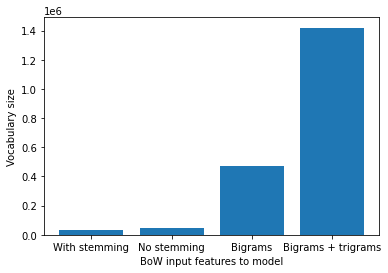

In [163]:
# YOUR CODE HERE
avg_vocab_size = np.mean(vocab_sizes)
avg_vocab_size_stemmed = np.mean(vocab_sizes_stemmed)
avg_vocab_size_bigrams = np.mean(vocab_sizes_bigrams)
avg_vocab_size_bigrams_trigrams = np.mean(vocab_sizes_bigrams_trigrams)
print("\nAverage vocab size without stemming: %0.0f" % avg_vocab_size)
print("Average vocab size with stemming: %0.0f" % avg_vocab_size_stemmed)
print("Average vocab size with bigrams: %0.0f" % avg_vocab_size_bigrams)
print("Average vocab size with bigrams + trigrams: %0.0f" % avg_vocab_size_bigrams_trigrams)

plt.figure()
x = np.arange(4)
plt.bar(x, [avg_vocab_size_stemmed, avg_vocab_size, avg_vocab_size_bigrams, avg_vocab_size_bigrams_trigrams])
plt.xticks(x, ["With stemming", "No stemming", "Bigrams", "Bigrams + trigrams"])
plt.xlabel("BoW input features to model")
plt.ylabel("Vocabulary size")
plt.show()


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [164]:
# YOUR CODE HERE
from scipy import sparse

# Global variable of all open classes.
OPEN_CLASSES = ['JJ', 'JJR', 'JJS',  'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WRB'] 

def get_vocabulary(reviews, use_pos, disc_close_classes):
  vocabulary = {}
  pos_tags = []
  for review in reviews:
    for sentence in review['content']:
      for word, pos_tag in sentence:
        word = word.lower()
        # Skip all close-classed words.
        if disc_close_classes:
          if pos_tag not in OPEN_CLASSES:
            continue
        # Add POS tag to string.
        if use_pos:
          word = ' '.join((word, pos_tag))
        # Save unseen words in vocabulary.
        if word not in vocabulary:
          vocabulary[word] = None
  return vocabulary
        
def extract_features(reviews, word_indices, use_pos):
  features = np.zeros((len(reviews), len(word_indices)))
  labels = np.empty(len(reviews))
  pos_tags = []
  for i, review in enumerate(reviews):
    for sentence in review['content']:
      for word, pos_tag in sentence:
        if use_pos:
          word = ' '.join((word, pos_tag))
        if word in word_indices:
          word_index = word_indices[word]
          features[i][word_index] += 1
    if review['sentiment'] == 'POS':
      labels[i] = 1
    else:
      labels[i] = 0
  return sparse.csr_matrix(features), labels

def svm_prediction(train_reviews, test_reviews, use_pos, disc_close_classes):
  vocabulary = get_vocabulary(train_reviews, use_pos, disc_close_classes)
  word_indices = {}
  for i, word in enumerate(vocabulary):
    word_indices[word] = i
  
  train_features, train_labels = extract_features(train_reviews, word_indices, use_pos)
  test_features, test_labels = extract_features(test_reviews, word_indices, use_pos)
  
  svm = sk.svm.LinearSVC()
  svm.fit(train_features, train_labels)
  
  test_preds = svm.predict(test_features)
  token_results = [1 if pred == label else 0 for pred, label in zip(test_preds, test_labels)]
  acc = calculate_acc(token_results)
  return acc, len(vocabulary)

def svm_cross_validation(reviews, n, use_pos=False, disc_close_classes=False):
  print("Running SVM experiments for {} different cross-validation splits".format(n))
  folds = n_fold_cv(reviews, n)

  test_accuracies = []
  vocab_sizes = []
  for i in range(n):
    test_reviews = folds[i]
    train_folds = [fold for j,fold in enumerate(folds) if j != i]
    train_reviews = [review for fold in train_folds for review in fold]

    test_acc, num_features = svm_prediction(train_reviews, test_reviews, use_pos, disc_close_classes)
    test_accuracies.append(test_acc)
    vocab_sizes.append(num_features)
    print("Completed experiment {}/{}: acc {:0.3f}".format(i+1, n, test_acc))
  return test_accuracies, vocab_sizes

svm_accuracies, vocab_sizes = svm_cross_validation(reviews, n=10, use_pos=False, disc_close_classes=False)
print("\nResults obtained with SVM classifier:")
print("Test accuracies:", svm_accuracies)
print("Average accuracy: %0.3f" % np.mean(svm_accuracies))
print("Average num features: %0.3f" % np.mean(vocab_sizes))

print("")

print("\nResults obtained with Naive Bayes classifier with smoothing:")
print("Average accuracy: %0.3f" % np.mean(test_accuracies_smoothing))

Running SVM experiments for 10 different cross-validation splits


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 1/10: acc 0.805


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 2/10: acc 0.815


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 3/10: acc 0.815


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 4/10: acc 0.860


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 5/10: acc 0.815


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 6/10: acc 0.790


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 7/10: acc 0.815
Completed experiment 8/10: acc 0.865


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 9/10: acc 0.885
Completed experiment 10/10: acc 0.860

Results obtained with SVM classifier:
Test accuracies: [0.805, 0.815, 0.815, 0.86, 0.815, 0.79, 0.815, 0.865, 0.885, 0.86]
Average accuracy: 0.832
Average num features: 45446.500


Results obtained with Naive Bayes classifier with smoothing:
Average accuracy: 0.815


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [165]:
# YOUR CODE HERE
svm_pos_accuracies, vocab_sizes_pos = svm_cross_validation(reviews, n=10, use_pos=True, disc_close_classes=False)

print("\nResults obtained with SVM classifier:")
print("Test accuracies:", svm_accuracies)
print("Average accuracy: %0.3f" % np.mean(svm_accuracies))
print("Average num features: %0.3f" % np.mean(vocab_sizes))


print("\nResults obtained with SVM classifier using POS tags:")
print("Test accuracies:", svm_pos_accuracies)
print("Average accuracy: %0.3f" % np.mean(svm_pos_accuracies))
print("Average num features: %0.3f" % np.mean(vocab_sizes_pos))

Running SVM experiments for 10 different cross-validation splits


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 1/10: acc 0.800
Completed experiment 2/10: acc 0.795
Completed experiment 3/10: acc 0.805


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 4/10: acc 0.840


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 5/10: acc 0.820


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 6/10: acc 0.820
Completed experiment 7/10: acc 0.845


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 8/10: acc 0.855


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 9/10: acc 0.855
Completed experiment 10/10: acc 0.835

Results obtained with SVM classifier:
Test accuracies: [0.805, 0.815, 0.815, 0.86, 0.815, 0.79, 0.815, 0.865, 0.885, 0.86]
Average accuracy: 0.832
Average num features: 45446.500

Results obtained with SVM classifier using POS tags:
Test accuracies: [0.8, 0.795, 0.805, 0.84, 0.82, 0.82, 0.845, 0.855, 0.855, 0.835]
Average accuracy: 0.827
Average num features: 54657.300


**Answer**

So we notice that incorporating POS-information in our features does not help in achieving higher performance (0.827 < 0.832). This result is perhaps somewhat surprising, as you would expect POS information of words to be beneficial for a SVM classifier. However, in the paper of Pang et al. (2002) the same thing happens: the SVM accuracy declines slightly when POS tags are added as features. It might be the case that it is more beneficial for this training set to keep features more 'general', in the sense that different POS-tags assigned to the same word will hinder the models ability to recognize the same word in test instances as it learned them in training instances (i.e. perhaps there is a discrepancy between the train set and test set so that the same words have a different meaning between train and test instances). It could also be that the POS tags of this dataset are not always correct (perhaps they are learned through a POS-tagger that makes mistakes).

All this is a bit of a stretch though, as it is hard to explain exactly why performance slightly drops after including POS-information.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [166]:
# YOUR CODE HERE
svm_pos_close_class_accs, vocab_sizes_cc = svm_cross_validation(reviews, n=10, use_pos=True, disc_close_classes=True)
print("\nResults obtained with SVM classifier:")
print("Test accuracies:", svm_accuracies)
print("Average accuracy: %0.3f" % np.mean(svm_accuracies))
print("Average num features: %0.3f" % np.mean(vocab_sizes))

print("\nResults obtained with SVM classifier using POS tags:")
print("Test accuracies:", svm_pos_accuracies)
print("Average accuracy: %0.3f" % np.mean(svm_pos_accuracies))
print("Average num features: %0.3f" % np.mean(vocab_sizes_pos))

print("\nResults obtained with SVM classifier discarding close-classed words:")
print("Test accuracies:", svm_pos_close_class_accs)
print("Average accuracy: %0.3f" % np.mean(svm_pos_close_class_accs))
print("Average num features: %0.3f" % np.mean(vocab_sizes_cc))

Running SVM experiments for 10 different cross-validation splits
Completed experiment 1/10: acc 0.790
Completed experiment 2/10: acc 0.830


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 3/10: acc 0.830


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 4/10: acc 0.840


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 5/10: acc 0.860


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 6/10: acc 0.815


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 7/10: acc 0.870


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Completed experiment 8/10: acc 0.860
Completed experiment 9/10: acc 0.845
Completed experiment 10/10: acc 0.820

Results obtained with SVM classifier:
Test accuracies: [0.805, 0.815, 0.815, 0.86, 0.815, 0.79, 0.815, 0.865, 0.885, 0.86]
Average accuracy: 0.832
Average num features: 45446.500

Results obtained with SVM classifier using POS tags:
Test accuracies: [0.8, 0.795, 0.805, 0.84, 0.82, 0.82, 0.845, 0.855, 0.855, 0.835]
Average accuracy: 0.827
Average num features: 54657.300

Results obtained with SVM classifier discarding close-classed words:
Test accuracies: [0.79, 0.83, 0.83, 0.84, 0.86, 0.815, 0.87, 0.86, 0.845, 0.82]
Average accuracy: 0.836
Average num features: 53604.300


**Answer**

It seems that the closed-class words indeed hinder performance, as the accuracy of only using open-class words increases slightly compared to previous results (0.836 > 0.832). The reason for this is that the closed-class words are often not meaningful for sentiment analysis (i.e. we can mainly detect sentiment from usage of nouns, verbs, adjectives, and adverbs). So the closed-class words add extra feature dimensions to an already high-dimensional feature vector that are generally not meaningful for classification. In other words, adding closed-class words introduces unneccesary signal noise to our SVM, and by discarding closed-class words, we actually gain performance.

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


**Table 1: overview of results**
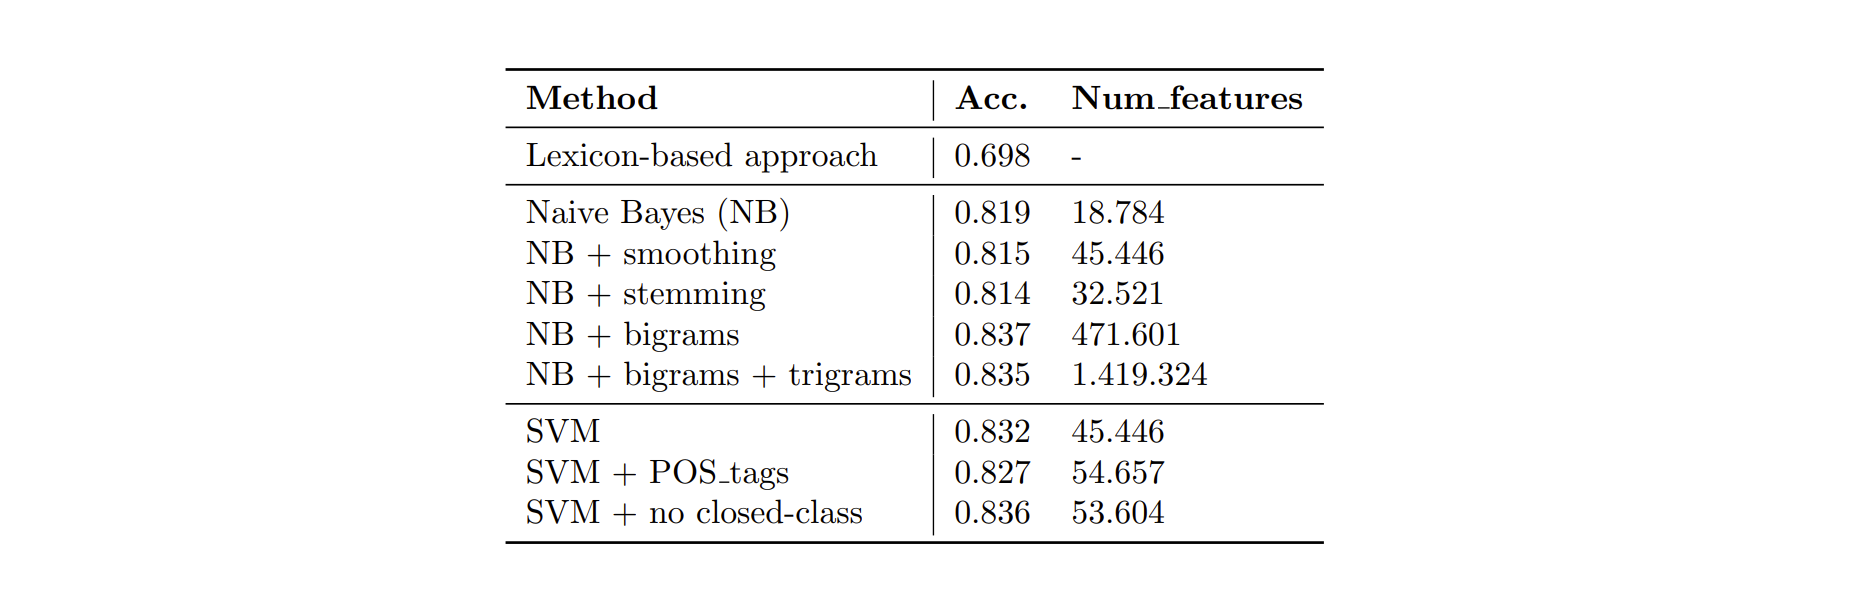

In this discussion, we will analyze and recap the results of this notebook.

First, we noticed that using a predefined **lexicon-based method** cannot compete with statistical or ML-based methods. So it is better to learn or model sentiment associations over words. The first technique we implemented that did this was **Naive Bayes**. This is a **Bag-of-Words-based approach**, meaning it is assumed that features are not dependent on each other other (syntactical structure is ignored). The downside of Naive Bayes is that features are generally dependent on each other - so we make a naive assumption.

Second, we made extensions for the Naive Bayes model to confront feature sparsity and overfitting problems. We discuss them one-by-one:


*   **Smoothing**: a possible problem of Naive Bayes is that we can have many zero probabilities because of data sparsity (we have unseen words). A solution for this is distributing extra probability to rare and unseen events, a technique called Laplace smoothing. Smoothing increased the number of features, but it did not improve performance for our task. Generally, smoothing is most suitable when we have few unseen events.

*   **Stemming**: when building a classification pipeline, we want our classifier to generalize to new samples, i.e., we do not want to overfit our training data. Stemming is a technique that transforms different inflections of a word to the same feature in the BoW vector space, thereby generalizing over words. The limitation of stemming is that we can generalize too much, such that we miss word-specific information. This is a general trade-off between generalization and having more specific features. Overall, stemming reduces the number of features and can be beneficial for performance, but for our task, stemming did not improve accuracy scores.

*   **N-grams**: The most significant disadvantage of using a BoW-based approach is that syntactic structure is disregarded, meaning that we can miss important context information and feature dependencies. To overcome this to some extent, we implemented bigrams and trigrams as extra features that take word-order into account. Adding bigrams and trigrams significantly increased the number of features, which can also be a limitation because it makes the whole pipeline computationally more demanding. However, for our task, adding bigrams and trigrams improved classification accuracies, indicating that context information can be very beneficial (e.g., modeling negations such as "not bad").

Thirdly, we implemented **SVMs** for our classification task. This method does not assume feature independence, as was the case with Naive Bayes. A downside of SVMs, however, is that they do not scale well to big data. We noticed that the SVMs outperformed the Naive Bayes classifier for our task, except when bigrams were added as features. 

Lastly, we analyzed the effects of adding **POS-tags** as features and using only open-class words as features. The benefit of adding POS-tags is that they are easy to add as features (they increase the feature space) but still can be seen as a step towards syntactic analysis. However, we did not notice an improvement in accuracy when adding POS-features. When discarding closed-class words, which are generally words that contain little to no semantic information, we noticed an improvement of accuracy and a slight decrease of features. This indicates that it can be beneficial for classification systems to limit the feature space to contain only meaningful features, thereby reducing noise and improving performance.

# Submission 


In [167]:
# Write your names and student numbers here:
# Jochem Soons    # 11327030
# Darius Barsony  # 11234342



**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 